In [2]:
from google.generativeai import GenerativeModel, configure
configure(api_key="YOUR_GEMNI_API_KEY")


In [2]:
classes = ["studying", "not_studying"]

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from diffusers import StableDiffusionPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from google.generativeai import GenerativeModel

# Load Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")

def generate_image(prompt, save_path):
    image = pipe(prompt).images[0]
    image.save(save_path)

# Function to get prompts from Gemini API
def get_prompts_from_gemini(class_names):
    model = GenerativeModel("gemini-pro")
    class_prompts = {}

    for class_name in class_names:
        prompt = f"Generate diverse and detailed image descriptions for the category '{class_name}'."
        response = model.generate_content(prompt)
        class_prompts[class_name] = response.text.split("\n")[:10]  # Extract top prompts

    return class_prompts

def generate_images(classes, num_images=5):
    os.makedirs("dataset_s", exist_ok=True)

    class_prompts = get_prompts_from_gemini(classes)

    for class_name in classes:
        os.makedirs(f"dataset_s/{class_name}", exist_ok=True)

        for i in range(num_images):
            prompt = np.random.choice(class_prompts[class_name])
            save_path = f"dataset_s/{class_name}/{i}.png"
            generate_image(prompt, save_path)



generate_images(classes, 5)   #for example i am taking less images  adjust numbers to 1000 to 10000 for better accuracy


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
# Install YOLOv8
!pip install ultralytics


  Using cached ultralytics-8.3.78-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [3]:


# Import necessary libraries
import os
import random
import shutil
import yaml
from ultralytics import YOLO

# Define dataset paths
base_path = "/content/dataset_s"
output_path = "/content/dataset"
image_train_path = os.path.join(output_path, "images/train")
image_val_path = os.path.join(output_path, "images/val")
label_train_path = os.path.join(output_path, "labels/train")
label_val_path = os.path.join(output_path, "labels/val")

# Create required directories
for path in [image_train_path, image_val_path, label_train_path, label_val_path]:
    os.makedirs(path, exist_ok=True)


class_dirs = {cls: idx for idx, cls in enumerate(classes)}




In [4]:
split_ratio = 0.8

# Function to generate YOLO labels and split dataset
def process_class(class_name, class_id):
    img_folder = os.path.join(base_path, class_name)
    images = [f for f in os.listdir(img_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    random.shuffle(images)  # Shuffle for randomness

    train_count = int(len(images) * split_ratio)

    for i, img in enumerate(images):
        img_src = os.path.join(img_folder, img)
        if i < train_count:
            img_dst = os.path.join(image_train_path, img)
            label_folder = label_train_path
        else:
            img_dst = os.path.join(image_val_path, img)
            label_folder = label_val_path

        # Copy image to correct split
        shutil.copy(img_src, img_dst)

        # Create label file
        label_filename = img.rsplit('.', 1)[0] + ".txt"
        label_dst = os.path.join(label_folder, label_filename)

        # YOLO format: class_id x_center y_center width height (full image box)
        with open(label_dst, "w") as f:
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

# Process each class folder
for class_name, class_id in class_dirs.items():
    process_class(class_name, class_id)

print("✅ Dataset split & YOLO labels generated.")


✅ Dataset split & YOLO labels generated.


In [5]:

# Dynamically create dataset.yaml file
names_yaml = "\n".join([f"  {idx}: {name}" for idx, name in enumerate(classes)])
dataset_yaml = f"""
path: /content/dataset
train: images/train
val: images/val

names:
{names_yaml}
"""

yaml_path = "/content/dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(f"✅ dataset.yaml created at {yaml_path}")

# Load YOLO model
model = YOLO("yolov8n.pt")  # Use 'yolov8l.pt' for better accuracy

# Train the model
model.train(data=yaml_path, epochs=50, imgsz=640, batch=16, device="cuda")




✅ dataset.yaml created at /content/dataset.yaml
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /content/dataset/labels/train... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1089.32it/s]

train: New cache created: /content/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/dataset/labels/val... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 633.34it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.27G      1.227      3.142      1.601         28        640: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.60s/it]

                   all          4          4    0.00381          1    0.00887    0.00583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.29G      1.461      3.199      1.778         26        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all          4          4    0.00379          1     0.0126     0.0076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.29G      1.401      3.115      1.768         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all          4          4    0.00379          1     0.0239    0.00806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.29G      1.549      3.095      1.879         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]

                   all          4          4    0.00374          1     0.0224    0.00706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.29G      1.177      2.981      1.628         32        640: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          4          4    0.00374          1     0.0146     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.31G     0.9839       2.94      1.489         34        640: 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all          4          4    0.00378          1      0.032     0.0234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.3G     0.7725      2.897      1.407         31        640: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]

                   all          4          4    0.00383          1      0.113     0.0608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.31G     0.6274      2.853      1.339         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.96it/s]

                   all          4          4    0.00375          1      0.293      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       1.3G     0.7919      2.832      1.423         31        640: 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all          4          4    0.00369          1      0.746      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.31G     0.5311      2.684      1.222         30        640: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all          4          4    0.00366          1      0.625      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.3G     0.4939      2.721      1.224         25        640: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.73it/s]

                   all          4          4    0.00368          1      0.664      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.31G     0.3267      2.529      1.086         32        640: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all          4          4    0.00368          1      0.625      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.3G     0.2853      2.424      1.073         34        640: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all          4          4    0.00364          1      0.643      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.31G     0.2393      2.362        1.1         30        640: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

                   all          4          4     0.0037          1      0.609      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       1.3G     0.2964      2.243      1.111         29        640: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]

                   all          4          4    0.00368          1      0.526      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.31G     0.4716      2.399      1.237         26        640: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]

                   all          4          4    0.00364          1      0.531      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.3G     0.3052      2.092      1.095         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.69it/s]

                   all          4          4    0.00363          1      0.664      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.31G     0.2551       2.08      1.057         29        640: 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]

                   all          4          4    0.00363          1      0.664      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.32G      0.379      2.225      1.131         27        640: 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

                   all          4          4    0.00366          1      0.746      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.31G     0.2553      2.059      1.071         28        640: 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all          4          4    0.00366          1      0.746      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.32G     0.2998      2.099      1.062         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]

                   all          4          4    0.00358          1      0.746      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.31G      0.204       1.82      1.021         32        640: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]

                   all          4          4    0.00358          1      0.746      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.32G     0.2588      2.015      1.044         28        640: 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all          4          4     0.0035          1      0.954      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.31G     0.2748      1.846      1.035         35        640: 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]

                   all          4          4     0.0035          1      0.954      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.32G     0.2438      1.855      1.057         31        640: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.09it/s]

                   all          4          4    0.00344          1      0.954      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.31G     0.2412       1.94      1.085         26        640: 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all          4          4    0.00344          1      0.954      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.32G     0.2444      1.761      1.025         27        640: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

                   all          4          4    0.00334          1      0.954      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.31G     0.2513       1.62      1.036         29        640: 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.23it/s]

                   all          4          4    0.00334          1      0.954      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.32G     0.1748      1.512      0.995         30        640: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.66it/s]

                   all          4          4    0.00332          1      0.954      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.31G     0.2435      1.597      1.048         25        640: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.88it/s]

                   all          4          4    0.00332          1      0.954      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.32G     0.1971      1.462     0.9636         38        640: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

                   all          4          4    0.00331          1      0.954      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.31G     0.1642      1.495      1.018         31        640: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.83it/s]

                   all          4          4    0.00331          1      0.954      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.32G     0.3288      1.557      1.005         36        640: 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all          4          4     0.0033          1      0.954      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.31G     0.2375      1.388      1.003         35        640: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all          4          4     0.0033          1      0.954      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.32G     0.2514      1.471      1.007         34        640: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.57it/s]

                   all          4          4     0.0033          1      0.954      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.31G     0.3951      1.421      1.103         34        640: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.68it/s]

                   all          4          4     0.0033          1      0.954      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.32G     0.1801      1.455     0.9949         30        640: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all          4          4    0.00329          1      0.929      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.31G     0.1655      1.397     0.9032         30        640: 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all          4          4    0.00329          1      0.929      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.32G     0.2235        1.3      0.945         33        640: 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]

                   all          4          4     0.0033          1      0.929      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.31G      0.331      1.251       1.07         27        640: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]

                   all          4          4     0.0033          1      0.929      0.869


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.32G      0.675      2.578      1.375         10        640: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


                   all          4          4    0.00329          1      0.929      0.853

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.31G     0.4912      2.527      1.253         10        640: 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all          4          4    0.00329          1      0.929      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.32G     0.7331      2.473      1.498         10        640: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all          4          4    0.00331          1      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.31G     0.8212      3.001      1.471         10        640: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]

                   all          4          4    0.00331          1      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.32G      1.209      2.989      1.924         10        640: 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all          4          4     0.0033          1      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.31G     0.6881      2.571      1.421         10        640: 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all          4          4     0.0033          1      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.32G     0.4628      2.324      1.171         10        640: 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

                   all          4          4      0.522      0.833      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.31G      0.431      2.122      1.224         10        640: 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          4          4      0.522      0.833      0.929      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.32G      0.785      2.574       1.69         10        640: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.51it/s]

                   all          4          4      0.623      0.833       0.68       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.31G     0.5923      2.526      1.319         10        640: 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all          4          4      0.623      0.833       0.68       0.68



50 epochs completed in 0.016 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


                   all          4          4      0.522      0.833      0.929      0.929
              studying          3          3      0.662      0.667      0.863      0.863
          not_studying          1          1      0.382          1      0.995      0.995
Speed: 0.3ms preprocess, 5.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78014c46e2d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Saving Screenshot 2025-02-23 072115.png to Screenshot 2025-02-23 072115 (3).png
✅ Uploaded image: Screenshot 2025-02-23 072115 (3).png

image 1/1 /content/Screenshot 2025-02-23 072115 (3).png: 480x640 1 studying, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


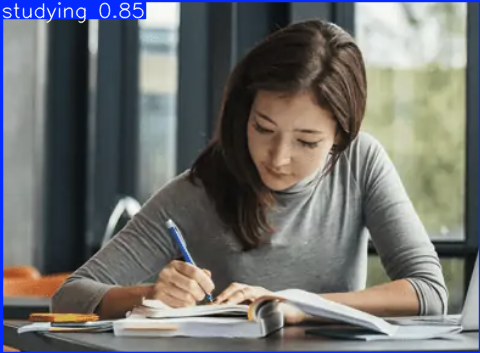

🔹 Detected Label: studying


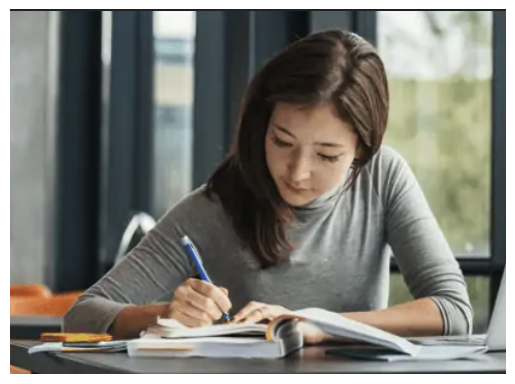

In [14]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get uploaded file name
print(f"✅ Uploaded image: {image_path}")

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/content/best (3).pt")

# Run inference
results = model(image_path)

# Show detections on the image
for result in results:
    result.show()  # This will display the image with bounding boxes

# Extract detected classes
detected_classes = [model.names[int(box.cls)] for box in results[0].boxes]

# Print detected class
if detected_classes:
    print(f"🔹 Detected Label: {detected_classes[0]}")
else:
    print("🔹 No detection found.")

# Display image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()


Saving Screenshot 2025-02-23 072925.png to Screenshot 2025-02-23 072925 (1).png
✅ Uploaded image: Screenshot 2025-02-23 072925 (1).png

image 1/1 /content/Screenshot 2025-02-23 072925 (1).png: 640x576 1 not_studying, 10.9ms
Speed: 4.3ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


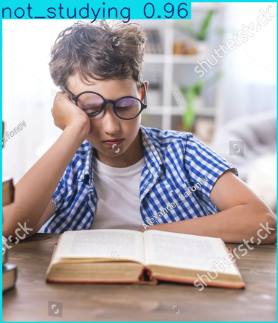

🔹 Detected Label: not_studying


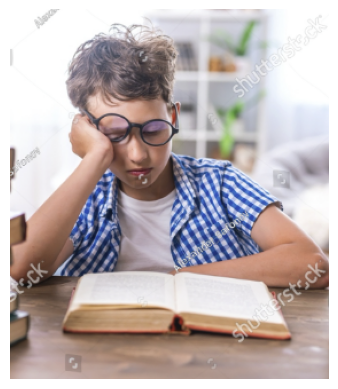

In [15]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get uploaded file name
print(f"✅ Uploaded image: {image_path}")
results = model(image_path)

# Show detections on the image
for result in results:
    result.show()  # This will display the image with bounding boxes

# Extract detected classes
detected_classes = [model.names[int(box.cls)] for box in results[0].boxes]

# Print detected class
if detected_classes:
    print(f"🔹 Detected Label: {detected_classes[0]}")
else:
    print("🔹 No detection found.")

# Display image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()
